# GRMHD 2D Manifold Visualizations
---

This notebook visualizes results generated by the script: scripts/grmhd_opening_angle_2d_manifold.py 
This notebook generates plots of the local minima / maxima and helps analyseing the loss manifold. Furthermore gifs of the resulting samples from the HGRFs can be produced

[1] https://github.com/AFD-Illinois/noisy

[2] https://github.com/aviadlevis/pynoisy

In [1]:
import pynoisy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import os
import scipy as sci

In [3]:
def krylov_projection(measurements, solver, deg=8, n_jobs=4):
    krylov = solver.run(source=measurements, nrecur=deg, verbose=0, std_scaling=False, n_jobs=n_jobs)
    k_matrix = krylov.data.reshape(deg, -1)
    result = np.linalg.lstsq(k_matrix.T, np.array(measurements).ravel(), rcond=None)
    coefs, residual = result[0], result[1]
    random_field = np.dot(coefs.T, k_matrix).reshape(*measurements.shape)
    random_field = xr.DataArray(random_field, coords=measurements.coords)
    return random_field

def resample_movie(movie, initial_frame, nt, nx, ny):
    assert initial_frame >= 0, 'Negative initial frame'
    assert (initial_frame + nt) < movie.t.size, 'Final frame: {} out of bounds for input of length: {}'.format(
        initial_frame + nt, movie.t.size)
    movie = movie[initial_frame:initial_frame + nt].interp_like(pynoisy.utils.get_grid(nx, ny))
    movie.attrs.update({'initial_frame': initial_frame})
    return movie  

def visualize_manifold(dataset):
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    dataset.loss.plot(ax=ax, add_labels=False)
    sidx, tidx  = np.unravel_index(np.argmin(dataset.loss), dataset.loss.shape)
    ax.scatter(dataset.temporal_angle[tidx], dataset.spatial_angle[sidx], s=50, c='r', marker='o', label='Global minima')
    ax.legend()
    cs = dataset.loss.plot.contour(ax=ax, cmap='RdBu_r')
    ax.clabel(cs, inline=1, fontsize=10)
    plt.title('Krylov loss: {}'.format(dataset.GRMHD),fontsize=17)
    plt.xlabel('Temporal angle [rad]', fontsize=13)
    plt.ylabel('Spatial angle [rad]', fontsize=13)
    print('Minimum: temporal angle: {} ; spatial angle: {}'.format(
        dataset.temporal_angle[tidx].data, dataset.spatial_angle[sidx].data))

## GRMHD Visualization

---

Load, visualize (and save if needed), crop the temporal axis and scale the spatial axis of GRMHD (.h5) movies.

In [21]:
directory = '../../GRMHD/'
slider = pynoisy.utils.slider_select_file(directory, filetype='h5')

interactive(children=(IntSlider(value=2, description='i', max=5), Output()), _dom_classes=('widget-interact',)…

<IPython.core.display.Javascript object>


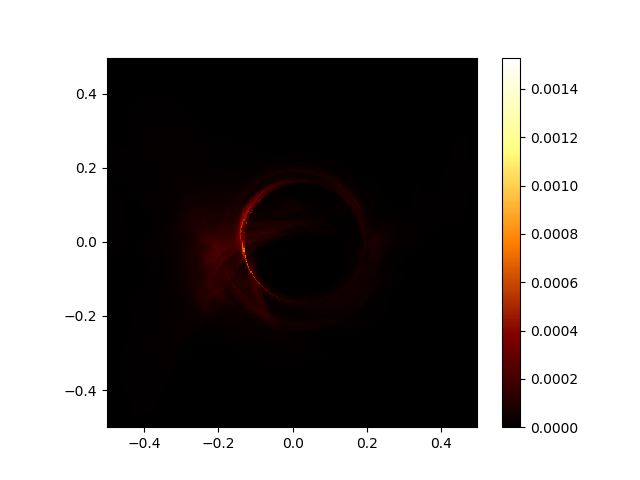

In [24]:
measurements = pynoisy.utils.load_grmhd(slider.result)

%matplotlib notebook
measurements.noisy_methods.get_animation()

In [17]:
"""
Crop temporal axis and rescale spatial axis

Notes
-----
Ma+0.5_inc10.h5: initial_frame = 400 
Ma0_inc10.h5: initial_frame = 500
Ma+0.94_inc10.h5: initial_frame = 600
"""
initial_frame = 500
nt, nx, ny = 64, 256, 256
measurements_scaled = resample_movie(measurements, initial_frame, nt, nx, ny)

## Loss Manifold Analysis

---
 - Load a precompute 2D loss manifold dataset (see: scripts/grmhd_opening_angle_2d_manifold.py)
 - Visualize the 2D manifold

In [4]:
directory = '../../GRMHD/approach5/'
slider = pynoisy.utils.slider_select_file(directory, filetype='nc')

interactive(children=(IntSlider(value=1, description='i', max=2), Output()), _dom_classes=('widget-interact',)…

<IPython.core.display.Javascript object>


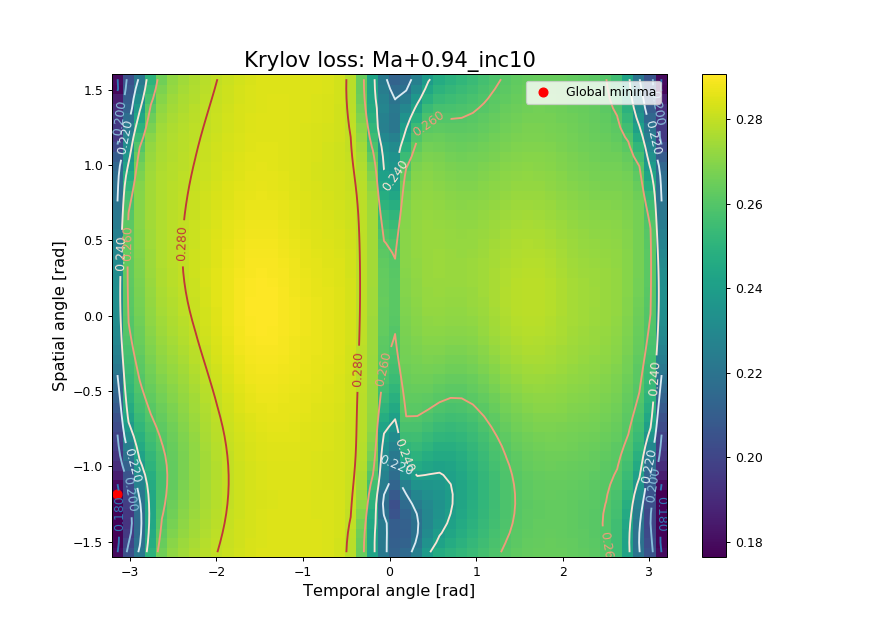

Minimum: temporal angle: -3.141592653589793 ; spatial angle: -1.1861115120696157


In [26]:
"""
Load and vizualize the manifold
"""
dataset = xr.load_dataset(slider.result)

# Minimum point (best fit)
sidx, tidx  = np.unravel_index(np.argmin(dataset.loss), dataset.loss.shape)
advection_angle, diffusion_angle = dataset.temporal_angle[tidx].data, dataset.spatial_angle[sidx].data

%matplotlib notebook
visualize_manifold(dataset)

In [11]:
ma000 = xr.load_dataset('../../GRMHD/approach5/spatio_temporal_loss_Ma0_inc10_64x64x64.nc')
ma050 = xr.load_dataset('../../GRMHD/approach5/spatio_temporal_loss_Ma+0.5_inc10_64x64x64.nc')
ma094 = xr.load_dataset('../../GRMHD/approach5/spatio_temporal_loss_Ma+0.94_inc10_64x64x64_21-Sep-2020-19:13:26.nc')

<IPython.core.display.Javascript object>


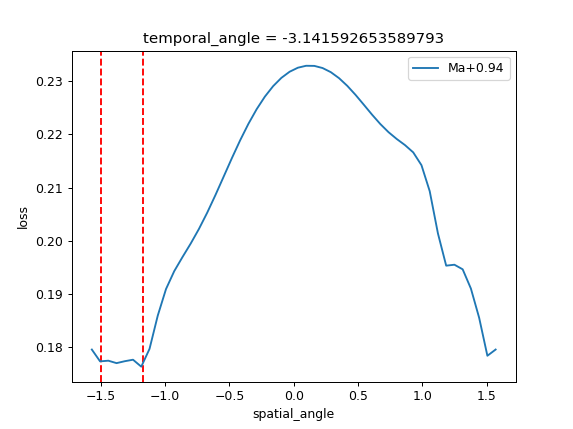

In [46]:
%matplotlib notebook
#ma000.loss.isel(temporal_angle=49).plot(label='Ma0')
#ma050.loss.isel(temporal_angle=49).plot(label='Ma+0.5')
plt.axvline(x=-1.17, color='r', linestyle='--')
plt.axvline(x=-1.5, color='r', linestyle='--')
ma094.loss.isel(temporal_angle=0).plot(label='Ma+0.94')
plt.legend()

## Generate HGRF samples

---

Generate HGRF samples to match estimated parameters and envelope of HGRF


In [17]:
"""
Generate and vizualize a GRF according to the parameters and estimate the envelope
"""
nt, nx, ny = 64, 64, 64
advection = pynoisy.advection.general_xy(nx, ny, opening_angle=-3.14)
diffusion = pynoisy.diffusion.general_xy(nx, ny, opening_angle=-1.4)
solver = pynoisy.forward.HGRFSolver(nx, ny, advection, diffusion)
grf = solver.run(num_frames=nt, n_jobs=4)

<IPython.core.display.Javascript object>


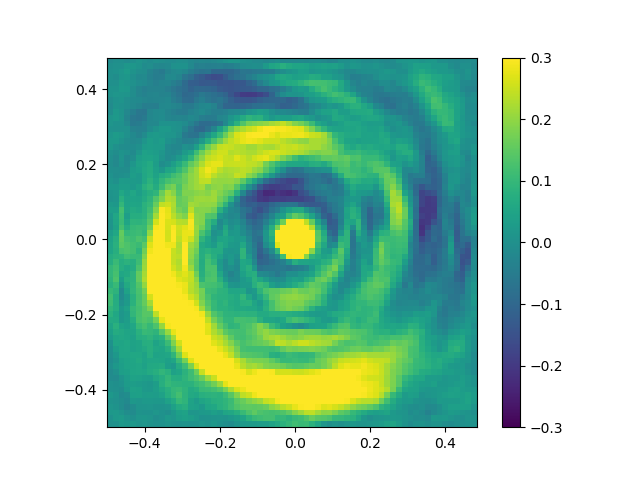

In [19]:
%matplotlib notebook
animation = grf.noisy_methods.get_animation(vmin=-0.3, vmax=0.3, cmap='viridis')

In [20]:
animation.save('spatio_temporal_loss/advection-3.14_diffusion-1.4.gif', writer='imagemagick')

In [27]:
animation.save('../../GRMHD/12 coefficients/HGRF_sample_Ma0_inc10_diffusion-1.05.gif', writer='imagemagick')

In [28]:
"""
Estimate envelope for that resolution

Notes
-----
Ma+0.5_inc10.h5: initial_frame = 400 
Ma0_inc10.h5: initial_frame = 500
Ma+0.94_inc10.h5: initial_frame = 600
"""
initial_frame = 500
measurements = pynoisy.utils.load_grmhd('../../GRMHD/Ma0_inc10.h5')
measurements_scaled = resample_movie(measurements, initial_frame, nt, nx, ny)
envelope = pynoisy.inverse.estimate_envelope(grf, measurements_scaled)

Traceback (most recent call last):
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/aviad/anaconda3/envs/eht/lib/python3.7/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


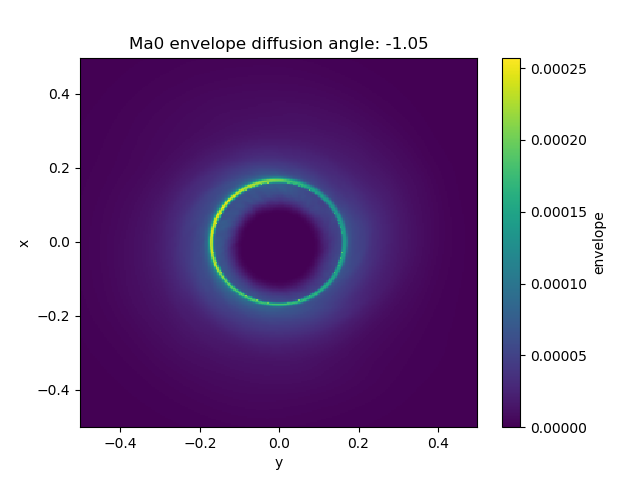

Text(0.5, 1.0, 'Ma0 envelope diffusion angle: -1.05')

In [29]:
%matplotlib notebook
envelope.plot()
plt.title('Ma0 envelope diffusion angle: {}'.format(diffusion.opening_angle))

<IPython.core.display.Javascript object>


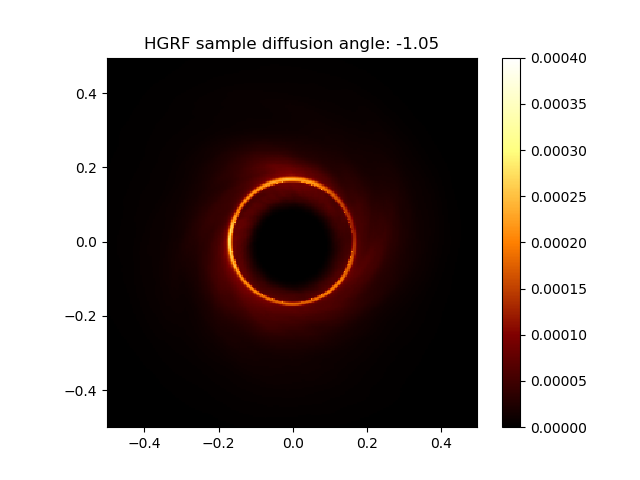

Text(0.5, 1.0, 'HGRF sample diffusion angle: -1.05')

In [40]:
"""
Generate movie
"""
alpha = 5.0
hgrf_movie = (envelope * np.exp(alpha*grf)).transpose('t', 'x', 'y', transpose_coords=False)
hgrf_movie.attrs.update({'alpha': alpha})
hgrf_movie.loc[{'x': 0, 'y':0}] = 0.0

%matplotlib notebook
animation = hgrf_movie.noisy_methods.get_animation(vmax=0.0004)
plt.title('HGRF sample diffusion angle: {}'.format(diffusion.opening_angle))

In [41]:
animation.save('../../GRMHD/12 coefficients/HGRF_enveloped_sample_Ma0_inc10_diffusion-1.05.gif', writer='imagemagick')